# Section 4.x: Budget on Source

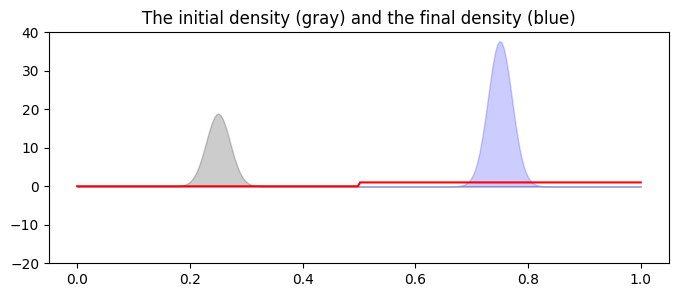

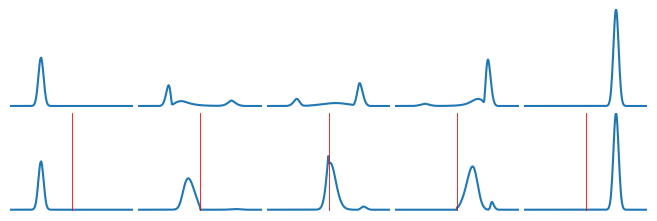

In [4]:
# --- Geodesics (same structure as your script) --------------------------------
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / (256 * 2)

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 40)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
H = np.zeros((K,))
H[128:] = 1.0
plt.plot(X, H, color="r", label="H")
plt.show()


T = 15                     # number of time steps (midpoints at (i+0.5)/T)
ll = (1.0, 1.0)            # time x space box size

time_mid = np.array([(i + 0.5) / T for i in range(T)])

xs = []

# WFR baseline
delta = 0.5/np.pi
x, _lists = computeGeodesic(rho_0, rho_1, T, ll, p=2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

# -------------------- Specify where H = 1 starts ------------------------------
# You can choose EITHER:
#   (A) by *index* (0-based cell index), or
#   (B) by *coordinate* in [0,1].
#
# Set exactly one of these; leave the other as None.

H_start_index = None      # e.g., 128 for "right half"; set to an int or leave None
H_start_x     = 0.5       # e.g., 0.5 for "right half"; set to a float in [0,1] or None

# Determine spatial resolution (K) from the baseline geodesic
K = xs[0].U.D[0].shape[1]           # number of spatial cells on the centered grid

if H_start_index is not None:
    j0 = int(np.clip(H_start_index, 0, K-1))
else:
    # default to coordinate specification
    if H_start_x is None:
        H_start_x = 0.5
    # map x in [0,1] to a cell index on the centered grid
    j0 = int(np.floor(H_start_x * K))
    j0 = int(np.clip(j0, 0, K-1))

# Build step mask: H=0 on [0, j0), H=1 on [j0, K)
H_vec = np.zeros((K,), dtype=float)
H_vec[j0:] = 1.0
H = np.tile(H_vec, (T, 1))          # repeat across time: shape (T, K)

# ζ-constrained (regional production cap)
Hs = [np.zeros((T, K)), np.zeros((T, K)), H]   # (Hρ, Hω, Hζ)
GL = np.zeros((T,))
GU = 0.1 * np.ones((T,))                       # capacity schedule (example)
x, _lists = computeGeodesic_inequality(
    rho_0, rho_1, T, ll,
    H=None, F=None, Hs=Hs, GL=GL, GU=GU,
    p=2.0, q=2.0, delta=delta, niter=3000,
    big_matrix=True, verbose=False
)
xs.append(x)

# --- Extract ρ, ω-speed, ζ-growth on the centered grid ------------------------
Ds, vs, gs = [], [], []
for x in xs:
    Ds.append(x.U.D[0])                 # ρ over time×space (T × Nx)
    v, g = speed_and_growth(x.V, 100)   # returns |ω| and ζ on centered grid
    vs.append(v[0])                     # |ω|
    gs.append(g)                        # ζ

# Grids (adjust Nx if needed)
Nx = Ds[0].shape[1]
x_grid = (np.arange(Nx) + 0.5) / Nx

# --- Choose five display times ≈ (0, .25, .5, .75, 1) -------------------------
targets = np.array([0.00, 0.25, 0.50, 0.75, 1.00])
idx = np.clip(np.round(T * targets).astype(int), 0, T)

# --- Fixed y-limits across ALL panels (ρ only here) ---------------------------
glob_min, glob_max = np.inf, -np.inf
for r in range(len(xs)):
    glob_min = min(glob_min, Ds[r].min())
    glob_max = max(glob_max, Ds[r].max())

ymin, ymax = glob_min - 0.5, glob_max
if ymin == ymax:
    ymin, ymax = ymin - 1.0, ymax + 1.0

# --- Compact 2×5 panel figure (no legends, ticks, labels, or spines) ----------
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(6.5, 2.1), sharex=True, sharey=True)

# Style for ρ (keep grayscale-friendly; no legend)
rho_style = dict(linestyle='solid', linewidth=1.5)

# Optional: mark where H jumps to 1 (off by default to keep the figure pristine)
mark_H_start = True
x_H_start = x_grid[j0]  # physical coordinate of the jump

for c, i in enumerate(idx):
    for r in range(rows):
        ax = axes[r, c]
        ax.plot(x_grid, Ds[r][i, :], **rho_style)

        if mark_H_start and r > 0:
            ax.axvline(x_H_start, linewidth=0.6, color='red')

        ax.set_xlim(0, 1)
        ax.set_ylim(ymin, ymax)

        # Remove anything graphical besides the curves
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ('top', 'right', 'left', 'bottom'):
            ax.spines[s].set_visible(False)

# Tight layout with minimal padding; no titles/supertitles
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.02, top=0.98, wspace=0.04, hspace=0.06)

# Save as vector PDF (for the paper) and a high-DPI PNG (for quick looks)
fig.savefig("figures/fig_zeta_constraint_series.png", dpi=600, bbox_inches="tight", pad_inches=0.01)

plt.show()

plt.close(fig)


In [10]:
# --------------------------------------------------------------
#  Exact‑pixel “total mass vs t” figure: 2211 px × 408 px
# --------------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -------- inputs from your session -----------------------------
# Expect: Ds is a list of arrays (one per solution) with shape (Nt, Nx).
# If Ds isn't defined yet, fall back to xs -> Ds.
try:
    Ds  # noqa: F821
except NameError:
    Ds = [x.U.D[0] for x in xs]  # one density time-series per solution

Nt, Nx = Ds[0].shape
# Time at cell centers: (i+0.5)/Nt in [0,1]
t = np.linspace(0, 1, Nt, endpoint=False) + 0.5 / Nt

# Total mass curves: discrete integral over space
mass_curves = [D.sum(axis=1) / Nx for D in Ds]

# -------- figure geometry for 2211×408 px at 600 dpi -----------
dpi_out         = 600
fig_width_inch  = 2211 / dpi_out - 0.09    # small fudge to compensate tight bbox
fig_height_inch =  408 / dpi_out - 0.124   # idem

rcParams.update({"font.size": 8, "text.usetex": False})

# Choose as many colors as needed; we’ll plot len(Ds) curves.
colours = ["red", "blue"]

fig = plt.figure(figsize=(fig_width_inch, fig_height_inch),
                 dpi=dpi_out, facecolor="white")
ax  = fig.add_axes([0.03, 0.04, 0.94, 0.93])  # fill almost everything

# -------- plot -------------------------------------------------
for m, c in zip(mass_curves, colours):
    ax.plot(t, m, marker='o', ms=2, lw=0.9, color=c)

# Reference lines (optional; helpful when masses hover near 1)
ax.axhline(1.0, color="0.4", lw=0.6, ls="--", zorder=0)
ax.axhline(2.0, color="0.4", lw=0.6, ls=":",  zorder=0)

# -------- axes cosmetics --------------------------------------
# Auto y-limits with a bit of headroom
ymin = min(float(m.min()) for m in mass_curves)
ymax = max(float(m.max()) for m in mass_curves)
pad  = 0.05 * (ymax - ymin if ymax > ymin else 1.0)

ax.set_xlim(0, 1)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["0", "0.5", "1"])
# Show 0.8 and 1.0 ticks if they fall inside the plotted range
yticks = []
yticks.append(1.0)
yticks.append(2.0)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{v:g}" for v in yticks])

ax.tick_params(axis="both", direction="out", length=2, pad=1)
for s in ("right", "top"):
    ax.spines[s].set_visible(False)

# Tiny “t” label just left of the x‑axis origin
ax.text(-0.03, -0.08, r"$t$", transform=ax.transAxes,
        ha="right", va="top", fontsize=9)

# -------- save -------------------------------------------------
os.makedirs("figures", exist_ok=True)
fig.savefig("figures/source_budget_total_mass_camera_ready.png",
            dpi=dpi_out, bbox_inches="tight", pad_inches=0, transparent=True)
plt.close(fig)
print("✓ Saved figures/source_budget_total_mass_camera_ready.png (2211×408 px @ 600 dpi)")


✓ Saved figures/source_budget_total_mass_camera_ready.png (2211×408 px @ 600 dpi)
